# CIFAR-10 dataset classification with CNNs

Author: Tanwi Mallick, adapting codes from Bethany Lusch, Prasanna Balprakash, Corey Adams, and Kyle Felker

In this notebook, we'll continue the CIFAR-10 problem using the Keras API (as included in the TensorFlow library) and incorporating convolutional layers.

First, the needed imports.

In [1]:
%matplotlib inline

import tensorflow as tf

import numpy
import matplotlib.pyplot as plt
import time

## CIFAR-10 data set

Again we'll load the cifar10 data set. CIFAR-10 dataset contains 32x32 color images from 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. If you haven't downloaded it already, it could take a while.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

y_train = y_train.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

This time we won't flatten the images. 

The training data (`X_train`) is a 3rd-order tensor of size (50000, 32, 32), i.e. it consists of 50000 images of size 32x32 pixels. 

`y_train` is a 50000-dimensional vector containing the correct classes ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') for each training sample.

## Convolutional neural network (CNN)

CNN is a type of deep learning model for processing data that has a grid pattern, such as images.

Let's use a small model that includes convolutional layers

- The Conv2D layers operate on 2D matrices so we input the images directly to the model.
    - The two Conv2D layers below learn 32 and 64 filters respectively. 
    - They are learning filters for 3x3 windows.
- The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
    - It downsamples by taking the maximum value in the window 
    - The pool size of (2, 2) below means the windows are 2x2. 
    - Helps in extracting important features and reduce computation
- The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

![conv layer](images/conv_layer.png)
Image credit: [Jason Brownlee](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/)

![conv layer](images/conv.png)
Image credit: [Anh H. Reynolds](https://anhreynolds.com/blogs/cnn.html)


<img src="images/MaxpoolSample2.png" width="600" hight="600" align="left"/>

In [3]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu')
        self.conv_2 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.25)
        self.dense_5 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_6 = tf.keras.layers.Dropout(0.5)
        self.dense_7 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_5(x)
        x = self.drop_6(x)
        x = self.dense_7(x)

        return x

### Simple training

Here is a concise way to train the network, like we did in the previous notebook. We'll see a more verbose approach below that allows more performance tuning.

In [4]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [5]:
# This took 43 seconds per epoch on my laptop
batch_size = 512
epochs = 3
lr = .01
history, cnn_model = train_network_concise(batch_size, epochs, lr)

2022-11-15 07:06:52.023491: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 07:06:53.657365: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38458 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2022-11-15 07:07:02.882120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-11-15 07:07:06.852403: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2022-11-15 07:07:11.308535: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


98/98 [==============================] - 11s 7ms/step - loss: 1.8276 - accuracy: 0.3312
Epoch 2/3
98/98 [==============================] - 1s 6ms/step - loss: 1.4521 - accuracy: 0.4736
Epoch 3/3
98/98 [==============================] - 1s 6ms/step - loss: 1.2901 - accuracy: 0.5421


Accuracy for test data.  The model should be better than the non-convolutional model even if you're only patient enough for three epochs. 

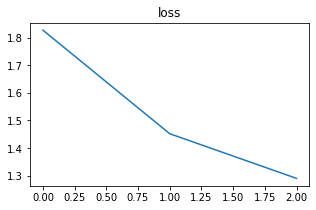

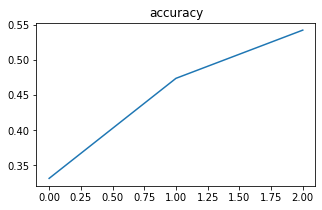

In [6]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

### Inference

With enough training epochs, the test accuracy should exceed 96.53%.

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html). 

In [8]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 0s - loss: 1.1287 - accuracy: 0.6012
accuracy: 60.12%
CPU times: user 524 ms, sys: 137 ms, total: 661 ms
Wall time: 478 ms


We can also again check the confusion matrix

In [9]:
from sklearn.metrics import confusion_matrix

print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
predictions = cnn_model.predict(x_test)
cm=confusion_matrix(y_test, numpy.argmax(predictions, axis=1), labels=list(range(10)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[680  29  74  23  28  15  17  11  83  40]
 [ 30 764   5  14   8  11  17  18  32 101]
 [ 77   8 408  46 175 139  87  39  15   6]
 [ 14  10  95 283 106 321 109  41   6  15]
 [ 32   6 103  32 612  70  73  64   7   1]
 [ 13   2  82  92  74 624  41  62   7   3]
 [  6   3  49  53 108  33 729  10   1   8]
 [ 15   2  30  37 100 117  12 669   3  15]
 [150  74  24  15  11  29  14   9 630  44]
 [ 50 155  10  18  13  13  36  50  42 613]]

Classification accuracy for each class:

0: 0.6800
1: 0.7640
2: 0.4080
3: 0.2830
4: 0.6120
5: 0.6240
6: 0.7290
7: 0.6690
8: 0.6300
9: 0.6130


### More verbose training

This approach explicitly handles the looping over data. It will be helpful in future weeks for diving in and optimizing

In [10]:
def compute_loss(y_true, y_pred):
    # if labels are integers, use sparse categorical crossentropy
    # network's final layer is softmax, so from_logtis=False
    scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # if labels are one-hot encoded, use standard crossentropy

    return scce(y_true, y_pred)  

In [11]:
def forward_pass(model, batch_data, y_true):
    y_pred = model(batch_data)
    loss = compute_loss(y_true, y_pred)
    return loss

In [12]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_epochs, model, opt):
    
    @tf.function()
    def train_iteration(data, y_true, model, opt):
        with tf.GradientTape() as tape:
            loss = forward_pass(model, data, y_true)

        trainable_vars = model.trainable_variables

        # Apply the update to the network (one at a time):
        grads = tape.gradient(loss, trainable_vars)

        opt.apply_gradients(zip(grads, trainable_vars))
        return loss

    for i_epoch in range(n_training_epochs):
        print("beginning epoch %d" % i_epoch)
        start = time.time()

        epoch_steps = int(50000/batch_size)
        dataset.shuffle(50000) # Shuffle the whole dataset in memory
        batches = dataset.batch(batch_size=batch_size, drop_remainder=True)
        
        for i_batch, (batch_data, y_true) in enumerate(batches):
            batch_data = tf.reshape(batch_data, [-1, 32, 32, 3])
            loss = train_iteration(batch_data, y_true, model, opt)
            
        end = time.time()
        print("took %1.1f seconds for epoch #%d" % (end-start, i_epoch))

In [13]:
def train_network(_batch_size, _n_training_epochs, _lr):

    cifar_model = CIFAR10Classifier()

    opt = tf.keras.optimizers.Adam(_lr)

    train_loop(_batch_size, _n_training_epochs, cifar_model, opt)

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset.shuffle(50000)

batch_size = 512
epochs = 3
lr = .01
train_network(batch_size, epochs, lr)

beginning epoch 0
took 1.5 seconds for epoch #0
beginning epoch 1
took 0.8 seconds for epoch #1
beginning epoch 2
took 0.8 seconds for epoch #2


# Homework: improve the accuracy of this model

Update this notebook to ensure more accuracy. How high can it be raised? Changes like increasing the number of epochs, altering the learning rate, altering the number of neurons the hidden layer, chnaging the optimizer, etc. could be made directly in the notebook. You can also change the model specification by expanding the network's layer. The current notebook's training accuracy is roughly 58.06%, although it varies randomly.

In [15]:
class CIFAR10Classifier(tf.keras.models.Model):

    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        self.conv_1 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_2 = tf.keras.layers.Conv2D(32, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_4 = tf.keras.layers.Dropout(0.2)
        self.conv_5 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_6 = tf.keras.layers.Conv2D(64, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_7 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_8 = tf.keras.layers.Dropout(0.2)
        self.conv_9 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.conv_10 = tf.keras.layers.Conv2D(128, [3, 3], activation='relu', kernel_initializer='he_uniform', padding='same')
        self.pool_11 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.drop_12 = tf.keras.layers.Dropout(0.2)
        self.dense_13 = tf.keras.layers.Dense(128, activation='relu')
        self.drop_14 = tf.keras.layers.Dropout(0.2)
        self.dense_15 = tf.keras.layers.Dense(10, activation='softmax')
        

    def call(self, inputs):

        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.pool_3(x)
        x = self.drop_4(x)
        
        x = self.conv_5(x)
        x = self.conv_6(x)
        x = self.pool_7(x)
        x = self.drop_8(x)
        
        
        x = self.conv_9(x)
        x = self.conv_10(x)
        x = self.pool_11(x)
        x = self.drop_12(x)
        
        
        x = tf.keras.layers.Flatten()(x)
        x = self.dense_13(x)
        x = self.drop_14(x)
        x = self.dense_15(x)

        return x

In [16]:
def train_network_concise(_batch_size, _n_training_epochs, _lr):

    cnn_model = CIFAR10Classifier()

    cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
    
    history = cnn_model.fit(x_train, y_train, batch_size=_batch_size, epochs=_n_training_epochs)
    return history, cnn_model

In [23]:
batch_size = 80
epochs = 15
lr = .1
history, cnn_model = train_network_concise(batch_size, epochs, lr)

Epoch 1/15
625/625 [==============================] - 2s 3ms/step - loss: 1.6940 - accuracy: 0.3785
Epoch 2/15
625/625 [==============================] - 2s 3ms/step - loss: 1.2267 - accuracy: 0.5598
Epoch 3/15
625/625 [==============================] - 2s 3ms/step - loss: 1.0032 - accuracy: 0.6471
Epoch 4/15
625/625 [==============================] - 2s 3ms/step - loss: 0.8591 - accuracy: 0.7007
Epoch 5/15
625/625 [==============================] - 2s 3ms/step - loss: 0.7690 - accuracy: 0.7337
Epoch 6/15
625/625 [==============================] - 2s 3ms/step - loss: 0.7004 - accuracy: 0.7568
Epoch 7/15
625/625 [==============================] - 2s 3ms/step - loss: 0.6416 - accuracy: 0.7770
Epoch 8/15
625/625 [==============================] - 2s 3ms/step - loss: 0.5977 - accuracy: 0.7893
Epoch 9/15
625/625 [==============================] - 2s 3ms/step - loss: 0.5604 - accuracy: 0.8025
Epoch 10/15
625/625 [==============================] - 2s 3ms/step - loss: 0.5288 - accuracy: 0.8143

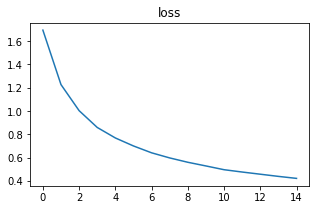

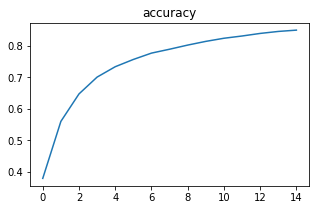

In [24]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [27]:
%%time
x_test_reshaped = numpy.expand_dims(x_test, -1)
scores = cnn_model.evaluate(x_test, y_test, verbose=2)
print("%s: %.2f%%" % (cnn_model.metrics_names[1], scores[1]*100))

313/313 - 0s - loss: 0.5826 - accuracy: 0.8108
accuracy: 81.08%
CPU times: user 606 ms, sys: 134 ms, total: 740 ms
Wall time: 528 ms


In [28]:
# The classificatio accuracy increased from 58.06% to 81.08%